In [ ]:
!pip install matplotlib==3.5.2

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
plt.style.use('seaborn-whitegrid')

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, precision_recall_curve, auc
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression

In [ ]:
y_test = pd.read_csv('data/test.tsv', sep='\t',
                     usecols=['label'])['label'].values

y_train = pd.read_csv('data/train.tsv', sep='\t',
                      usecols=['label'])['label'].values

y_dev = pd.read_csv('data/dev.tsv', sep='\t',
                    usecols=['label'])['label'].values

In [ ]:
X_test = pd.read_csv('data/features/test.csv', nrows=1)
X_test.columns

Index(['bert_cosine_distance', 'prediction_seamese_bert', '3_grams_jaccard',
       '2_grams_jaccard', '4_grams_jaccard', 'predictions_raw', 'predictions',
       'shortest_path_distance', 'wup_similarity', 'wm_distance'],
      dtype='object')

# Get model

In [ ]:
def get_log_regr(usecols):
  X_test = pd.read_csv('data/features/test.csv', usecols=usecols)
  X_train = pd.read_csv('data/features/train.csv', usecols=usecols)
  X_dev = pd.read_csv('data/features/dev.csv', usecols=usecols)
  X_train.replace(np.inf, 10, inplace=True)
  X_test.replace(np.inf, 10, inplace=True)
  X_dev.replace(np.inf, 10, inplace=True)

  model = LogisticRegression(max_iter=1000)  # XGBClassifier(**best_params)
  # fit the model
  model.fit(X_train, y_train)

  y_pred_test = model.predict(X_test)
  y_pred_dev = model.predict(X_dev)

  y_proba_test = model.predict_proba(X_test)[:, 1]
  y_proba_dev = model.predict_proba(X_dev)[:, 1]

  print(accuracy_score(y_test, y_pred_test))
  print(accuracy_score(y_dev, y_pred_dev))

  # importance = model.coef_[0]

  return model, y_pred_test, y_pred_dev, X_test, X_dev, X_train

In [ ]:
feature_names = ['Cosine dist', 'Siamese NN', '3-grams', '2-grams', '4-grams',
                'RoBERTa predictions raw', 'RoBERTa predictions binary',
                'WordNet shortest path', 'WordNet Wu and Palmer', 'Word Mover\'s Distance']

usecols = ['bert_cosine_distance', 'prediction_seamese_bert', '3_grams_jaccard',
          '2_grams_jaccard', '4_grams_jaccard', 'predictions_raw', 'predictions',
          'shortest_path_distance', 'wup_similarity', 'wm_distance']

model, y_pred_test, y_pred_dev, X_test, X_dev, X_train = get_log_regr(usecols)

0.924625
0.937125


# Functions

### ROC curve

In [ ]:
def roc_auc(X, y):  
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
  y_probabilities = model.predict_proba(X)[:, 1]


  fpr, tpr, thr_roc = roc_curve(y, y_probabilities)
  auc_roc = auc(fpr, tpr)

  precision, recall, thr_pr = precision_recall_curve(y, y_probabilities)
  auc_pr = auc(recall, precision)

  ax1.plot(fpr, tpr,
          label=f'AUC = {auc_roc*100:.2f}%',
          linewidth=3)

  ax2.plot(recall, precision,
          label=f'AUC = {auc_pr*100:.2f}%',
          linewidth=2, color='darkblue')


  ax1.set_xlabel('False Positive Rate')
  ax1.set_ylabel('True Positive Rate')
  ax1.set_title('ROC-curve')
  ax1.legend()
  ax1.grid(visible=True)

  ax2.legend()
  ax2.set_xlabel('Recall')
  ax2.set_ylabel('Precision')
  ax2.set_title('Recall-Precision curve')
  ax2.grid(visible=True)

  plt.show()

### Feature importance

In [ ]:
def feature_importance(model):
  # get importance
  importance = model.coef_[0]  # feature_importances

  plt.figure(figsize=(8,6))
  # plot feature importance
  ax = sns.barplot(x=importance, y=X_train.columns.values, orient='h',
                  palette='rocket')
  ax.bar_label(ax.containers[0], fmt='%.2f')
  ax.set_xlim(right=14, left=-5)
  plt.yticks(range(len(importance)), feature_names)
  plt.show()


### Confusion matrix

In [ ]:
def confusion(y_true, y_pred):  
  cf_matrix = confusion_matrix(y_true, y_pred)

  group_names = ['True Neg','False Pos','False Neg','True Pos']
  group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
  group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  labels = [f'{v1}\n\n{v2}\n\n{v3}' for v1, v2, v3 in zip(group_names,group_counts, group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='rocket')

# Without BERT predictions

In [ ]:
feature_names = [
                #  'Cosine dist', 
                #  'Siamese NN', 
                # '3-grams', 
                #  '2-grams', '4-grams',
                # 'RoBERTa predictions raw', 'RoBERTa predictions binary',
                # 'WordNet shortest path', 'WordNet Wu and Palmer', 
                 'Word Mover\'s Distance'
                 ]

usecols = [
          'bert_cosine_distance', 
          'prediction_seamese_bert', 
          '3_grams_jaccard',
          '2_grams_jaccard', 
          '4_grams_jaccard', 
          'predictions_raw', 'predictions',
          'shortest_path_distance', 'wup_similarity', 
          'wm_distance'
           ]
          
model, y_pred_test, y_pred_dev, X_test, X_dev, X_train = get_log_regr(usecols)

0.924625
0.937125


In [ ]:
accuracy_score(y_test, X_test['predictions'])

0.919625

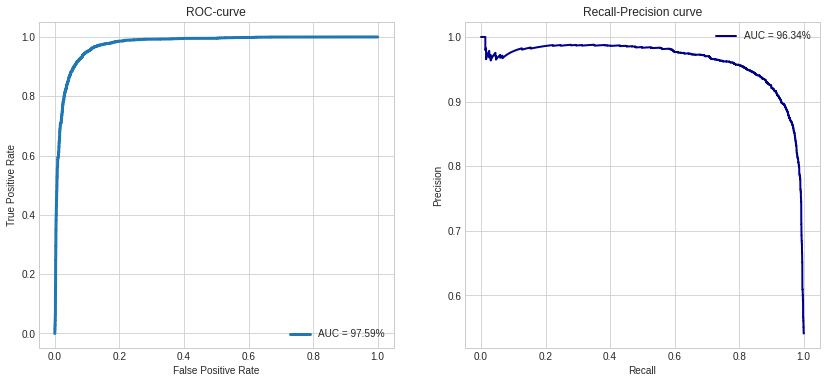

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
y_probabilities = X_test['predictions_raw']


fpr, tpr, thr_roc = roc_curve(y_test, y_probabilities)
auc_roc = auc(fpr, tpr)

precision, recall, thr_pr = precision_recall_curve(y_test, y_probabilities)
auc_pr = auc(recall, precision)

ax1.plot(fpr, tpr,
          label=f'AUC = {auc_roc*100:.2f}%',
          linewidth=3)

ax2.plot(recall, precision,
          label=f'AUC = {auc_pr*100:.2f}%',
          linewidth=2, color='darkblue')


ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC-curve')
ax1.legend()
ax1.grid(visible=True)

ax2.legend()
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Recall-Precision curve')
ax2.grid(visible=True)

plt.show()

In [ ]:
model.coef_[0]

array([ 2.00665683, -0.27323599,  0.65846073, -0.46189274,  0.07632945,
       11.64601347, -2.68975239,  1.4599834 , -0.8702744 , -0.35363012])

In [ ]:
del sorted

In [ ]:
features_w_coefs = {k: v for k,v in zip(usecols, model.coef_[0])}
# sort_res = {k: v for k, v in sorted(features_w_coefs.items(), key=lambda item: item[1])}
# sort_res

In [ ]:
dict(sorted(features_w_coefs.items(), key=lambda item: item[0], reverse=True))

{'2_grams_jaccard': -0.4618927378764362,
 '3_grams_jaccard': 0.658460730849945,
 '4_grams_jaccard': 0.07632945375586102,
 'bert_cosine_distance': 2.006656827253117,
 'prediction_seamese_bert': -0.273235993257245,
 'predictions': -2.6897523915757726,
 'predictions_raw': 11.646013472144181,
 'shortest_path_distance': 1.4599833964996878,
 'wm_distance': -0.35363012041380365,
 'wup_similarity': -0.8702743985240236}

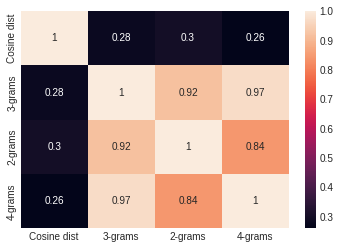

In [ ]:
sns.heatmap(abs(X_test.corr()), annot=True, xticklabels=feature_names, yticklabels=feature_names);

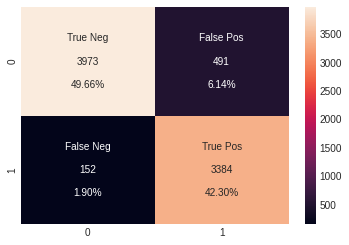

In [ ]:
confusion(y_test, X_test['predictions'])

In [ ]:
print(classification_report(y_test, X_test['predictions']))

              precision    recall  f1-score   support

           0       0.96      0.89      0.93      4464
           1       0.87      0.96      0.91      3536

    accuracy                           0.92      8000
   macro avg       0.92      0.92      0.92      8000
weighted avg       0.92      0.92      0.92      8000



In [ ]:
X_train.head()

,bert_cosine_distance,prediction_seamese_bert,3_grams_jaccard,2_grams_jaccard,4_grams_jaccard,predictions_raw,predictions,shortest_path_distance,wup_similarity,wm_distance
0,0.991096,0.808118,0.333333,0.483871,0.235294,0.000793,0,0.933332,0.989999,0.070316
1,0.987829,0.901397,0.461538,0.727273,0.384615,0.996700,1,0.999998,0.999998,0.000000
2,0.938906,0.942084,0.125000,0.333333,0.000000,0.002786,0,0.902005,0.921855,0.121349
3,0.973281,0.832014,0.187500,0.400000,0.062500,0.998303,1,0.999999,0.999999,0.000000
4,0.985249,0.728312,0.285714,0.538462,0.142857,0.997327,1,0.999998,0.999998,0.000000


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB


# names of classifiers
classifiers = [
               'Logistic Regression',
]

# initialize classifiers
models = [
          LogisticRegression(max_iter=1000),
          ]

changed = ['original data', 
          'feature selection (1)',
          'feature selection (2)', 
          'feature selection (3)',
          'feature selection (4)',
          'feature selection (5)',
           'feature selection (6)',
           'feature selection (7)',
           'feature selection (8)',
           'feature selection (9)',
           'feature selection (10)',
                ]

classifiers_table = []
features_table = []
accuracy_table = []


for i in range(len(models)):
  for j in changed:

    if 'feature selection' in j:

      clf = LogisticRegression(max_iter=1000)
      clf = clf.fit(X_train, y_train)

      max_features = int(j[-2])

      selecter = SelectFromModel(clf, prefit=True, max_features=max_features)
      x_train = selecter.transform(X_train)
      x_test = selecter.transform(X_test)
      
      model = models[i].fit(x_train, y_train)
      predictions = model.predict(x_test)

      accuracy_table.append(accuracy_score(y_test, predictions))
      features_table.append(j)
      classifiers_table.append(classifiers[i])
    else:
      model = models[i].fit(X_train, y_train)
      predictions = model.predict(X_test)

      accuracy_table.append(accuracy_score(y_test, predictions))
      features_table.append(j)
      classifiers_table.append(classifiers[i])
    

In [ ]:
# create table with mean accuracy per folds
# for each combination
df = pd.DataFrame ({
    'Classifier': classifiers_table,
    'Feature selection': features_table,
    'Accuracy on test set': accuracy_table
})

df.style.background_gradient(cmap='Blues')

In [ ]:
'feature selection (10)'.split('(').split(')')

AttributeError: ignored

# SIAMESE NN

In [ ]:
import pandas as pd
import nltk

from nltk.corpus import stopwords
import re
import gensim.downloader as api
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# tokenizer
from nltk.tokenize import word_tokenize

# NN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

# import and initialize early stopping
from tensorflow.keras.callbacks import EarlyStopping
stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:

model_wiki = api.load('fasttext-wiki-news-subwords-300')
nltk.download('punkt')
nltk.download('stopwords')

# downloading a set of stop-words
STOPWORDS = set(stopwords.words('english'))

df_train = pd.read_csv('/content/data/train.tsv', sep='\t')
df_test = pd.read_csv('/content/data/test.tsv', sep='\t')
df_dev = pd.read_csv('/content/data/dev.tsv', sep='\t')


In [ ]:
############################ TEXT PREPROCESSING ############################

def text_preprocess(text, stop_words=False):
    '''
    Accepts text (a single string) and
    a parameters of preprocessing
    Returns preprocessed text

    '''
    # clean text from non-words
    text = re.sub(r'\W+', ' ', text).lower()

    text = re.sub(r'\d+', ' ', text).lower()

    # tokenize the text
    tokens = word_tokenize(text)

    if stop_words:
        # delete stop_words
        tokens = [token for token in tokens if token not in STOPWORDS]

    return tokens


x_train1 = [text_preprocess(t, stop_words=True) for t in df_train['sentence1']]
x_train2 = [text_preprocess(t, stop_words=True) for t in df_train['sentence2']]
y_train = df_train['label'].values

x_test1 = [text_preprocess(t, stop_words=True) for t in df_test['sentence1']]
x_test2 = [text_preprocess(t, stop_words=True) for t in df_test['sentence2']]
y_test = df_test['label'].values


x_dev1 = [text_preprocess(t, stop_words=True) for t in df_dev['sentence1']]
x_dev2 = [text_preprocess(t, stop_words=True) for t in df_dev['sentence2']]
y_dev = df_dev['label'].values

 [('new', 1), ('born', 2), ('first', 3), ('also', 4), ('river', 5)] 
finished


In [ ]:
################################ TOKENIZE ################################

DICT_SIZE = 15000

# creating a dictionary with most used words
# where num of words = DICT_SIZE
tokenizer = Tokenizer(num_words=DICT_SIZE)
total = x_train1 + x_train2 + x_test1 + x_test2 + x_dev1 + x_dev2
tokenizer.fit_on_texts(total)

print('='*80 + '\n', list(tokenizer.word_index.items())[:5], '\n' + '='*80)

print('finished')


In [ ]:
############################### ADD PADDING ###############################
MAX_LEN = 128

# 1
X_train1 = tokenizer.texts_to_sequences(x_train1)
X_train_pad1 = pad_sequences(X_train1, maxlen=MAX_LEN)

X_test1 = tokenizer.texts_to_sequences(x_test1)
X_test_pad1 = pad_sequences(X_test1, maxlen=MAX_LEN)

X_dev1 = tokenizer.texts_to_sequences(x_dev1)
X_dev_pad1 = pad_sequences(X_dev1, maxlen=MAX_LEN)

# 2
X_train2 = tokenizer.texts_to_sequences(x_train2)
X_train_pad2 = pad_sequences(X_train2, maxlen=MAX_LEN)

X_test2 = tokenizer.texts_to_sequences(x_test2)
X_test_pad2 = pad_sequences(X_test2, maxlen=MAX_LEN)

X_dev2 = tokenizer.texts_to_sequences(x_dev2)
X_dev_pad2 = pad_sequences(X_dev2, maxlen=MAX_LEN)

3959 words were skipped. Some of them:
['_', 'valea', 'buccinidae', 'berasia', 'zemgale', 'horace', 'palghar', 'lottiidae', 'trenčín', 'geometridae', 'guillermo', 'dahanu', 'dunedin', 'gonzalo', 'biddle', 'björn', 'guadalajara', 'dunfermline', 'pérez', 'olt', 'lillian', 'jiul', 'medford', 'ashland', 'malmö', 'abilene', 'martínez', 'hammerstein', 'suceava', 'shawnee', 'gianni', 'talcott', 'eoacmaea', 'eoacmaeidae', 'audubon', 'josé', 'lyell', 'amasya', 'galveston', 'townshend', 'cheadle', 'kilroy', 'oecomys', 'retzius', 'goldsborough', 'jürgen', 'toowoomba', 'monrovia', 'nikolai', 'björkman']


In [ ]:
############################### WEIGHT MATRIX ###############################
def create_weight_matrix(model, second_model=False):
    '''
    Accepts word embedding model
    and the second model, if provided
    Returns weight matrix of size m*n, where
    m - size of the dictionary
    n - size of the word embedding vector

    '''
    vector_size = model.get_vector('like').shape[0]
    w_matrix = np.zeros((DICT_SIZE, vector_size))
    skipped_words = []

    for word, index in tokenizer.word_index.items():
        if index < DICT_SIZE:
            try:
                w_matrix[index] = model.get_vector(word)
            except KeyError:
                skipped_words.append(word)

    print(f'{len(skipped_words)} words were skipped. Some of them:')
    print(skipped_words[:50])
    return w_matrix


weight_matrix = create_weight_matrix(model_wiki)


In [ ]:
############################### CONCAT VALUES ###############################

X_train = [X_train_pad1, X_train_pad2]
X_test = [X_test_pad1, X_test_pad2]
X_dev = [X_dev_pad1, X_dev_pad2]

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 128, 300)     4500000     ['input_3[0][0]',                
                                                                  'input_4[0][0]']                
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 256)         439296      ['embedding_1[0][0]',      

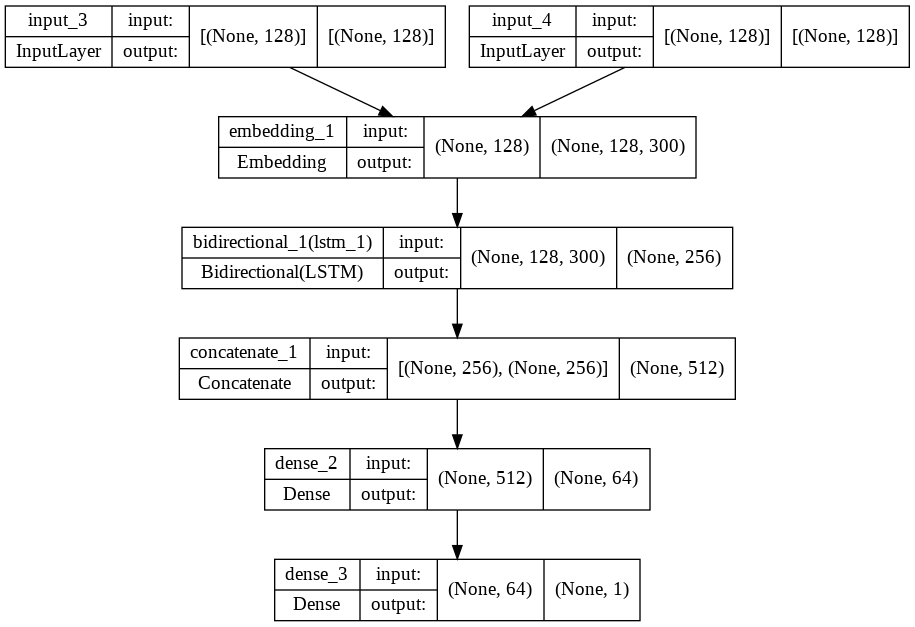

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras import layers, utils, callbacks, optimizers, regularizers

In [ ]:
############################### NEURAL NETWORK ###############################
input_q1 = Input(shape = X_train[0].shape[1])
input_q2 = Input(shape = X_train[0].shape[1])

embedding_layer = Embedding(DICT_SIZE,
                            300,
                            input_length = X_train[0].shape[1],
                            weights = [weight_matrix],
                            trainable=False)


embedded_sequences_q1 = embedding_layer(input_q1)
embedded_sequences_q2 = embedding_layer(input_q2)

bilstm_layer = Bidirectional(LSTM(128, return_sequences=False))

x1 = bilstm_layer(embedded_sequences_q1)
x2 = bilstm_layer(embedded_sequences_q2)

distance = layers.Concatenate()([x1, x2])
x = Dense(64, activation="relu")(distance)
preds = Dense(1, activation="sigmoid")(x)

model = Model(inputs=[input_q1, input_q2], outputs=preds)
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])



model.summary()
utils.plot_model(model, show_shapes=True, expand_nested=True)

Epoch 1/100
772/772 [==============================] - 40s 41ms/step - loss: 0.6863 - accuracy: 0.5574 - val_loss: 0.6853 - val_accuracy: 0.5596 - lr: 0.0010
Epoch 2/100
772/772 [==============================] - 31s 41ms/step - loss: 0.6888 - accuracy: 0.5661 - val_loss: 0.6825 - val_accuracy: 0.5624 - lr: 0.0010
Epoch 3/100
772/772 [==============================] - 32s 41ms/step - loss: 0.6397 - accuracy: 0.6255 - val_loss: 0.6257 - val_accuracy: 0.6600 - lr: 0.0010
Epoch 4/100
772/772 [==============================] - 31s 40ms/step - loss: 0.5823 - accuracy: 0.6954 - val_loss: 0.5993 - val_accuracy: 0.6924 - lr: 0.0010
Epoch 5/100
772/772 [==============================] - 31s 40ms/step - loss: 0.5467 - accuracy: 0.7232 - val_loss: 0.5982 - val_accuracy: 0.6917 - lr: 0.0010
Epoch 6/100
772/772 [==============================] - 31s 40ms/step - loss: 0.5162 - accuracy: 0.7445 - val_loss: 0.6191 - val_accuracy: 0.6804 - lr: 0.0010
Epoch 7/100
771/772 [============================>.]

KeyboardInterrupt: ignored

In [ ]:
es = callbacks.EarlyStopping(
    monitor='val_loss', patience=5, verbose=1, restore_best_weights=True
)

rlp = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=2, min_lr=1e-10, mode='min', verbose=1
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_dev, y_dev),
    batch_size=64, 
    epochs=100,
    callbacks=[es, rlp]
)